# Repository Hotspots

We are going to see find out which files are changed the most. For this we are using a dataset created from JUnit4 with JQAssistant and the following Cypher query:

```MATCH
   (commit:Git:Commit),
   (commit)-[:CONTAINS_CHANGE]->(change:Git:Change),
   (author:Git:Author)-[:COMMITTED]->(commit),
   (change)-[]->(file:File)
RETURN DISTINCT
   commit.sha AS sha,
   commit.date AS date,
   commit.time AS time,
   commit.author AS author,
   author.email AS author_email,
   author.identString AS author_id,
   commit.committer AS commiter,
   commit.message AS message,
   change.modificationKind AS modificationKind,
   file.fileName AS file```

With this we have the commits history for all the files.

# Setting Up

In [1]:
import pandas as pd
import calendar
history = pd.read_csv("../datasets/git_history_junit4.gz")

# Exploring Data

In [2]:
history.head()

,sha,date,time,author,author_email,author_id,commiter,message,modificationKind,file
0,3a5c6b4d08f408c8ca6a8e0bae71a9bc5a8f97e8,2020-08-02,20:24:18 +0200,Rahul Nagekar <rahul.nagekar1@gmail.com>,rahul.nagekar1@gmail.com,Rahul Nagekar <rahul.nagekar1@gmail.com>,GitHub <noreply@github.com>,Deprecated since jdk9 replacing constructor in...,NaN,NaN
1,Replacing deprecated datatype constructors,M,src/main/java/junit/framework/Assert.java,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,44cd8f80dbac11849a42a5d73fc9b5ddc75cd1b4,2016-12-01,21:35:45 +0100,Kevin Cooney <kcooney@google.com>,kcooney@users.noreply.github.com,Kevin Cooney <kcooney@users.noreply.github.com>,Stefan Birkner <github@stefan-birkner.de>,Change generics on ExpectedException.expectCau...,M,src/main/java/org/junit/internal/matchers/Thro...
3,44cd8f80dbac11849a42a5d73fc9b5ddc75cd1b4,2016-12-01,21:35:45 +0100,Kevin Cooney <kcooney@google.com>,kcooney@users.noreply.github.com,Kevin Cooney <kcooney@users.noreply.github.com>,Stefan Birkner <github@stefan-birkner.de>,Change generics on ExpectedException.expectCau...,M,src/main/java/org/junit/rules/ExpectedExceptio...
4,8baae6ecd6e719c8de58bac1a191de2badd78ed3,2016-12-08,19:16:32 +0100,Kevin Cooney <kcooney@google.com>,kcooney@users.noreply.github.com,Kevin Cooney <kcooney@users.noreply.github.com>,Kevin Cooney <kcooney@google.com>,Do not use @Override when implementing methods...,NaN,NaN


## Times Each File was Modified

In [3]:
file_change_count = history["file"]

# Reject rows with NaN
file_change_count = file_change_count.dropna()

# Clean up
file_change_count = file_change_count.value_counts().rename_axis("file").reset_index(name="changes")
file_change_count = file_change_count.sort_values("file")
file_change_count = file_change_count.set_index("file")

file_change_count.head()

,changes
file,
.bashemtote/tags/-f,1
.bashemtote/tags/first_fail_ensurecommitted,1
.bashemtote/tags/recent_fail_ensurecommitted,1
.classpath,8
.cvsignore,4


### Average Number of Changes

Usually, how many changes does a file receive? And how many changes is too much?

In [18]:
changes_mean = file_change_count["changes"].mean()
changes_mean

1.9396914446002804

In [7]:
file_change_count["distance"] = file_change_count.apply(lambda x: x["changes"] / changes_mean, axis=1)
file_change_count.head()

,changes,distance
file,,
.bashemtote/tags/-f,1,0.515546
.bashemtote/tags/first_fail_ensurecommitted,1,0.515546
.bashemtote/tags/recent_fail_ensurecommitted,1,0.515546
.classpath,8,4.124367
.cvsignore,4,2.062184


### Top Most Changed Files

In [22]:
top_file_change_count = top_file_change_count[top_file_change_count["distance"] >= 10]
top_file_change_count = top_file_change_count.sort_values("changes", ascending=False)
top_file_change_count

,changes,distance
file,,
src/test/java/org/junit/tests/AllTests.java,44,22.684020
src/main/java/org/junit/runners/ParentRunner.java,34,17.528561
build.xml,31,15.981923
pom.xml,29,14.950832
src/main/java/org/junit/rules/ExpectedException.java,26,13.404194
src/main/java/org/junit/runners/Parameterized.java,25,12.888648
src/main/java/org/junit/experimental/theories/internal/AllMembersSupplier.java,24,12.373102
src/main/java/org/junit/runners/BlockJUnit4ClassRunner.java,24,12.373102
src/main/java/org/junit/Assert.java,23,11.857556


### Hotspot diagram

The previous data identifies those files which receive a lot of commits. But it isn't good for a global view.

<AxesSubplot:>

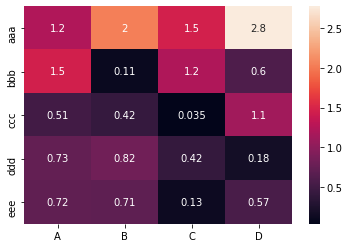

In [24]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Index= ['aaa', 'bbb', 'ccc', 'ddd', 'eee']
Cols = ['A', 'B', 'C', 'D']
df = DataFrame(abs(np.random.randn(5, 4)), index=Index, columns=Cols)

sns.heatmap(df, annot=True)